## Advanced Lane Finding Project
The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

## Camera calibration

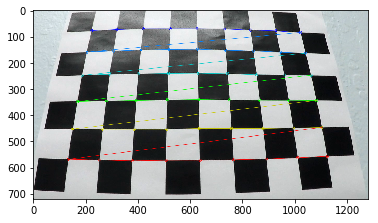

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration3.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        plt.imshow(img)

In [3]:
imgpoints[0].shape
#len(objpoints)
#corners[0]

(54, 1, 2)

In [4]:
imgpoints[0]

array([[[  224.43092346,    78.436203  ]],

       [[  319.51428223,    74.21487427]],

       [[  421.4828186 ,    70.77714539]],

       [[  524.48974609,    70.75636292]],

       [[  625.84558105,    70.84218597]],

       [[  729.51196289,    71.51357269]],

       [[  830.59899902,    75.96363831]],

       [[  927.90789795,    78.63024902]],

       [[ 1022.02966309,    84.68180847]],

       [[  205.50428772,   160.35827637]],

       [[  307.03656006,   155.89237976]],

       [[  411.68115234,   151.83822632]],

       [[  518.58734131,   150.41996765]],

       [[  627.54626465,   148.61694336]],

       [[  735.53601074,   152.78121948]],

       [[  841.90167236,   156.35575867]],

       [[  943.6394043 ,   159.96246338]],

       [[ 1041.45678711,   163.5737915 ]],

       [[  187.18074036,   248.13812256]],

       [[  292.53887939,   244.10835266]],

       [[  401.88345337,   243.3427124 ]],

       [[  516.87750244,   240.51312256]],

       [[  629.69616699,   240.2

## Distortion Correction

In [5]:
img = cv2.imread('camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
#plt.imshow(dst)
cv2.imwrite('camera_cal/calibration3_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"));

### Visualize Undistortion using dist and undist:

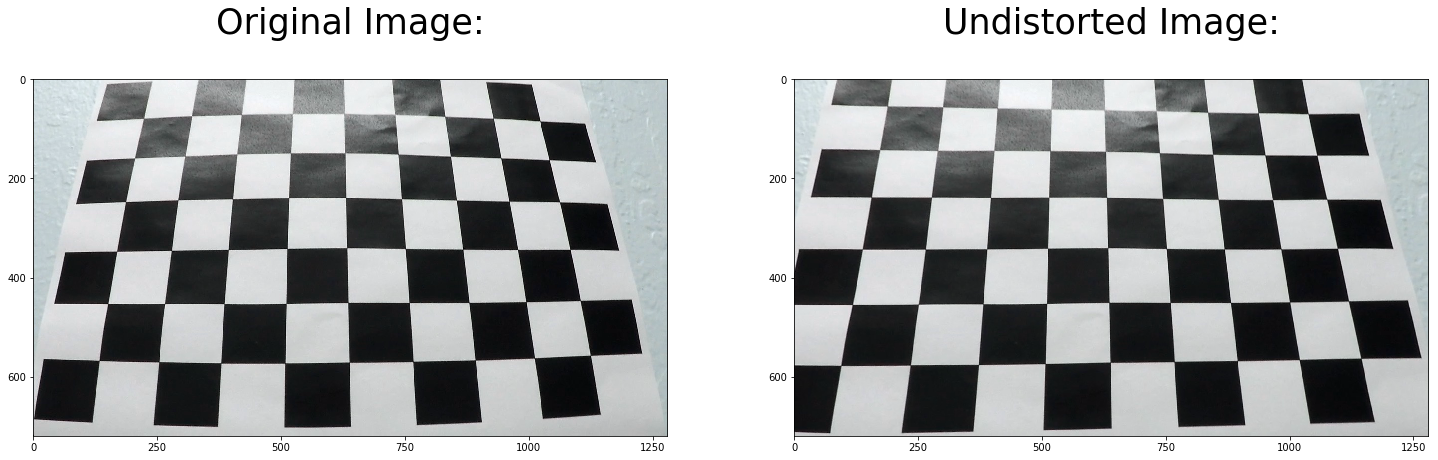

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10));

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img);
ax1.set_title('Original Image:\n', fontsize=35)
ax2.imshow(dst);
ax2.set_title('Undistorted Image:\n', fontsize=35)
plt.savefig('output_images/distortion_11.png', bbox_inches="tight")

### Function to unwarp an image:

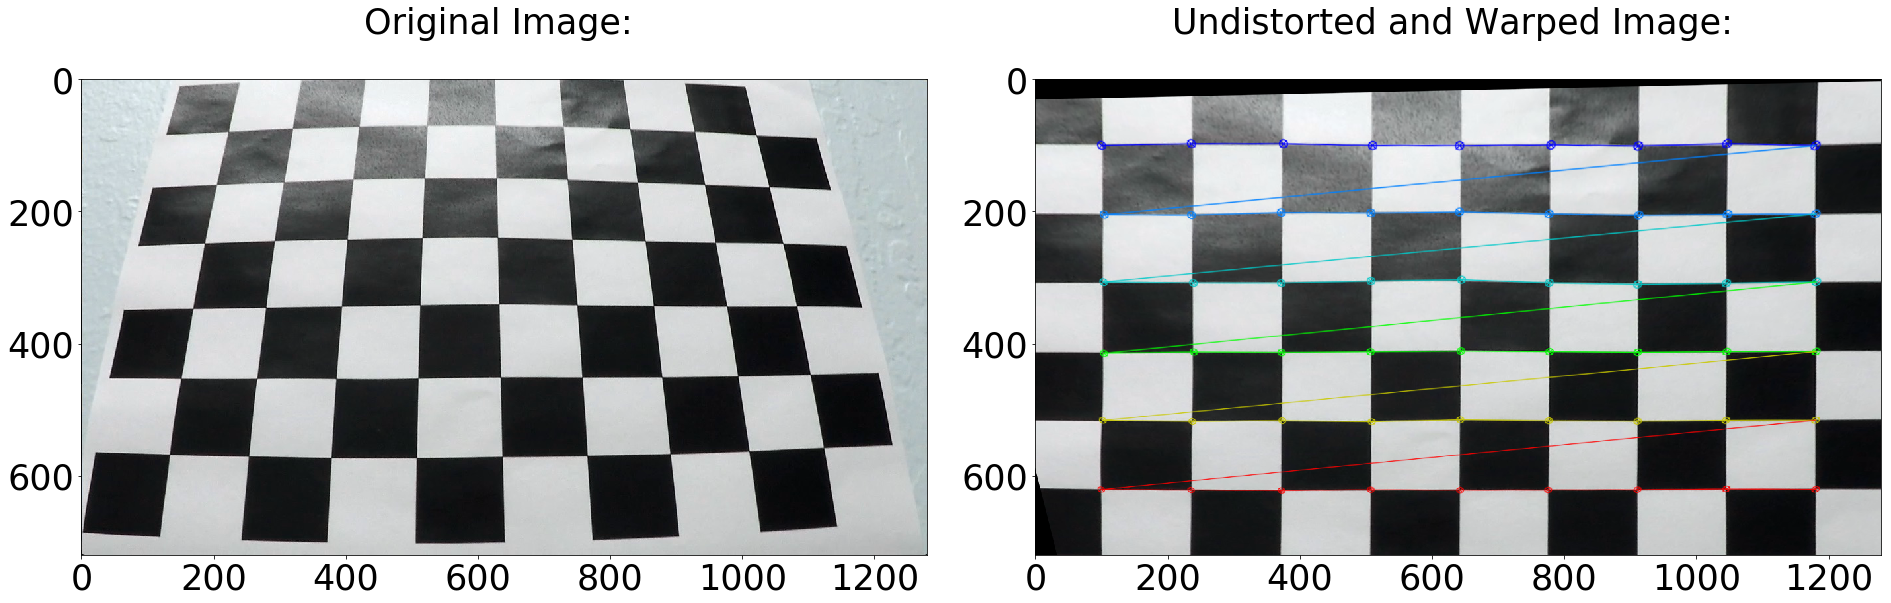

In [7]:
dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb" ))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('camera_cal/calibration3.jpg')

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx=nx, ny=ny, mtx=mtx, dist=dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0],
                          corners[nx-1],
                          corners[-1],
                          corners[-nx]])
        dst = np.float32([[offset, offset],
                          [img_size[0]-offset, offset],
                          [img_size[0]-offset, img_size[1]-offset], 
                          [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img)
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/corners_unwarp2.png', bbox_inches="tight")

## Building the pipeline of fuctions for better readability and Maitenance

In [8]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def undistort(img):
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)

In [9]:
def pipeline(op=None):    
    path = 'test_images/test2.jpg'
    img = cv2.imread(path)
    test_img = bgr_to_rgb(img)
    if op == 'Undistorted':
        new_img = undistort(img)
        plotter(test_img, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), op)
        plt.savefig('output_images/undistorted.png'.format(op), bbox_inches="tight")

    if op == 'Sobel X':
        new_img = undistort(img)
        new_img = sobel_x(img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/sobel_x.png'.format(op), bbox_inches="tight")

    if op == 'Sobel Y':
        new_img = undistort(img)
        new_img = sobel_y(img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/sobel_y.png'.format(op), bbox_inches="tight")

    if op == 'Gradient Magnitude':
        new_img = undistort(img)
        new_img = gradient_magnitude(img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/gradient_magnitude.png'.format(op), bbox_inches="tight")
 
    if op == 'Gradient Direction':
        new_img = undistort(img)
        new_img = gradient_direction(img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/gradient_direction.png'.format(op), bbox_inches="tight")
 
    if op == 'Color Thresholds':
        new_img = undistort(img)
        new_img = color_thresholds(img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/color_thresholds.png'.format(op), bbox_inches="tight")

    if op == 'Multi-Thresholded Binary':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/thresholded_binary.png'.format(op), bbox_inches="tight")

    if op == 'Region Masking':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img = region_of_interest(new_img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/region_masked.png'.format(op), bbox_inches="tight")

    if op == 'Perspective Transform':
        new_img = undistort(img)
        #new_img = combined_thresholds(new_img)
        #new_img = region_of_interest(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        plotter(test_img, new_img, op)
        plt.savefig('output_images/perspective_transform.png'.format(op), bbox_inches="tight")

    if op == 'Sliding Windows':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img = region_of_interest(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(new_img)
        plotter(test_img, windows_img, op)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/sliding_windows.png'.format(op), bbox_inches="tight")
   
    if op == 'Shaded Lanes':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img = region_of_interest(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit,leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(new_img)
        shades_img, ploty, left_fitx, right_fitx,left_fit, right_fit = shaded_lanes(new_img, left_fit, right_fit)
        plotter(test_img, shades_img, op)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig('output_images/shaded_lanes.png'.format(op), bbox_inches="tight")
        

    if op == 'Radius of Curvature in Pixels':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty,leftx_base, rightx_base = sliding_windows(new_img)
        left_curverad, right_curverad = roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx)
        print('Left Radius of Curvature: {0:2f} pixels\nRight Radius of Curvature: {1:2f} pixels\n'.format(left_curverad, right_curverad))
        
    if op == 'Radius of Curvature in Meters':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        windows_img, ploty, left_fitx, right_fitx, left_fit,right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(new_img)
        left_curverad, right_curverad,avg_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, lefty, rightx,righty)
        print('Left Radius of Curvature: {0:2f} pixels\nRight Radius of Curvature: {1:2f} pixels\nRadius of Curvature: {2:2f} '.format(left_curverad, right_curverad,avg_curverad))

    if op == 'Camera Offset':
        new_img = undistort(img)
        new_img = combined_thresholds(new_img)
        new_img, M, Minv = transform_perspective(new_img)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(new_img)
        width = img.shape[1]
        img_center = width/2
        camera = offset(img_center, leftx_base, rightx_base)
        print('Offset from Lane Center: {0:2f} meters\n'.format(camera))
        
    if op == 'Lane Mapping':
        undistorted_img = undistort(img)
        new_img = combined_thresholds(undistorted_img)
        warped_img, M, Minv = transform_perspective(new_img)
        new_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(warped_img)
        new_img = lane_mapping(img.shape[:2], warped_img, Minv, ploty, left_fitx, right_fitx, cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
        plotter(test_img, new_img, op)
        plt.savefig('output_images/lane_mapping.png'.format(op), bbox_inches="tight")
        #


In [10]:
def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0}'.format(plot_title), fontsize=15)

## 2.1 Distortion Correction

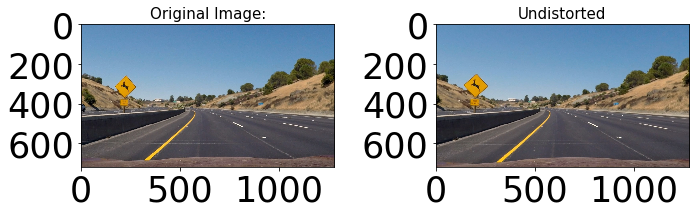

In [11]:
pipeline(op='Undistorted')

## 2.2 Color & Gradient Thresholds

### Sobel X

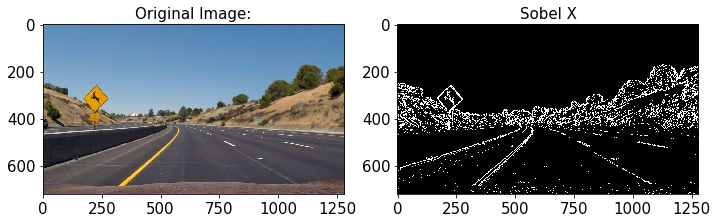

In [12]:
def sobel_x(img, threshold_MIN=15, threshold_MAX=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
    return binary_output

pipeline(op='Sobel X')

### Sobel Y

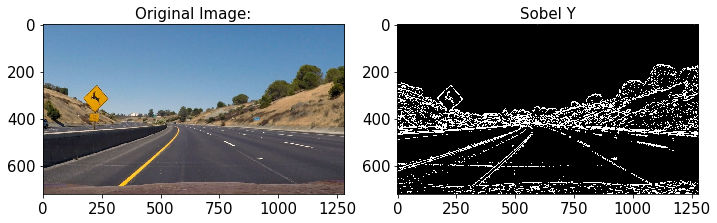

In [13]:
def sobel_y(img, threshold_MIN=15, threshold_MAX=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold_MIN) & (scaled_sobel <= threshold_MAX)] = 1
    return binary_output

pipeline(op='Sobel Y')

### Gradient Magnitude

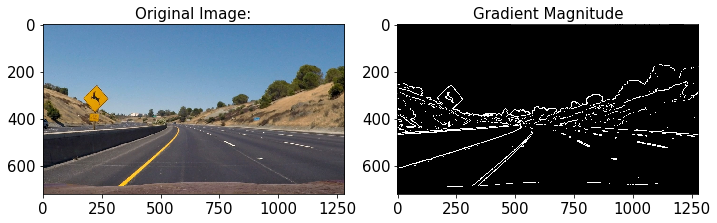

In [14]:
def gradient_magnitude(img, sobel_kernel=9, mag_threshold=(60, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & (gradmag <= mag_threshold[1])] = 1
    return binary_output

pipeline(op='Gradient Magnitude')

### Gradient Direction

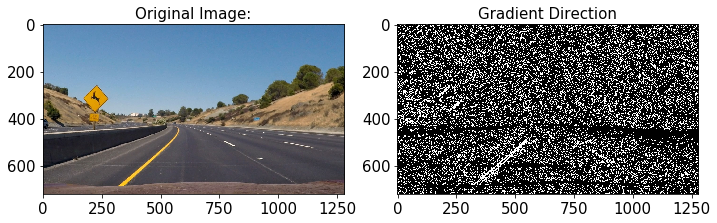

In [15]:
def gradient_direction(img, sobel_kernel=9, thresh=(0.7, 1.1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_grad_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output =  np.zeros_like(abs_grad_dir)
    binary_output[(abs_grad_dir >= thresh[0]) & (abs_grad_dir <= thresh[1])] = 1
    return binary_output

pipeline(op='Gradient Direction')

### Color Thresholds

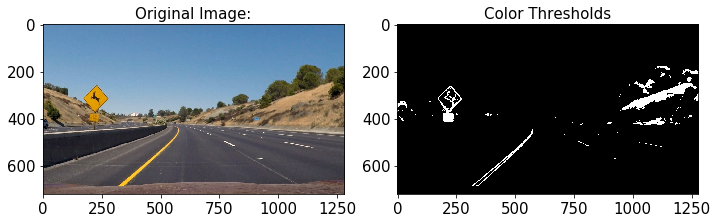

In [16]:
def color_thresholds(img, HLS_s_threshold=(60, 255), HSV_v_threshold=(120,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    bgr = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    
    s_channel = hls[:,:,2]
    l_channel = luv[:,:,0]
    b_channel = bgr[:,:,2]
    
    s_threshold_min = 180
    s_threshold_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_threshold_min) & (s_channel <= s_threshold_max)] = 1
    
    l_threshold_min = 225
    l_threshold_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_threshold_min) & (l_channel <= l_threshold_max)] = 1
    
    
    b_threshold_min = 155
    b_threshold_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_threshold_min) & (b_channel <= b_threshold_max)] = 1
    
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    return combined_binary

pipeline(op='Color Thresholds')


### Multi-Thresholded Binary Image

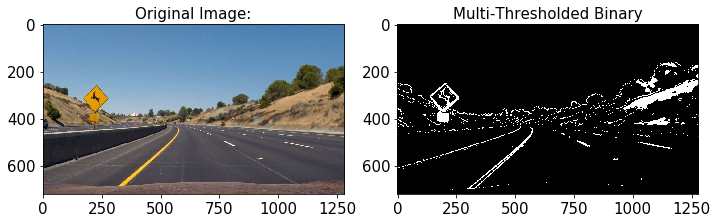

In [17]:
def combined_thresholds(img):
    binary_x = sobel_x(img)
    binary_y = sobel_y(img)
    mag = gradient_magnitude(img)
    direct = gradient_direction(img)
    color = color_thresholds(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary_output = np.zeros_like(img)
    #binary_output[color == 1] = 1
    binary_output[(binary_x == 1) & (binary_y == 1) & (mag == 1) | (color == 1) | (mag == 1) & (direct == 1)] = 1
    return binary_output

pipeline(op='Multi-Thresholded Binary')

### Thresholding Effectiveness

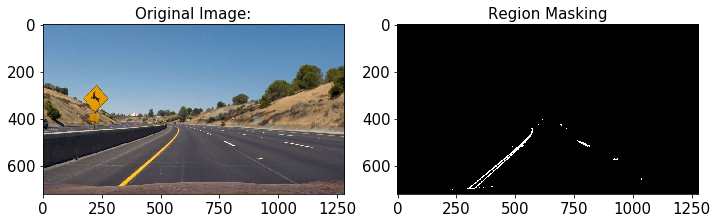

In [18]:
def region_of_interest_left(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.49, height*0.55),
                        (width*0.49, height*0.55),
                        (width*0.3, height),
                        (width*0.15, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_left = cv2.bitwise_and(img, mask)
    return masked_image_left

def region_of_interest_right(img):
    width = img.shape[1]
    height = img.shape[0]
    vertices = np.array([[(width*0.51, height*0.55),
                        (width*0.51, height*0.55),
                        (width*0.95, height),
                        (width*0.8, height)]], 
                        dtype=np.int32)
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image_right = cv2.bitwise_and(img, mask)
    return masked_image_right

def region_of_interest(img):
    mask_left = region_of_interest_left(img)
    mask_right = region_of_interest_right(img)
    masked_image = cv2.addWeighted(mask_left, 1.0, mask_right, 1.0, 0)
    return masked_image

pipeline(op='Region Masking')

## 4. Perspective Transform

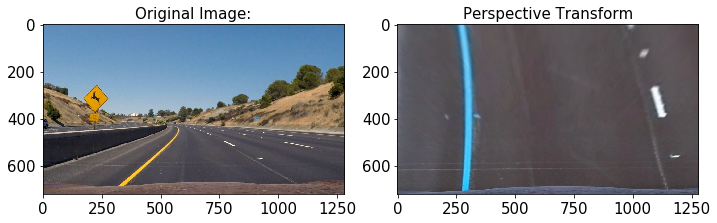

In [19]:
def transform_perspective(img):
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_output, M, Minv

pipeline(op='Perspective Transform')


## 5. Detect lane pixels and fit to find the lane boundary

In [20]:
class Line():
    
    def __init__(self):
        
        self.detected = False
        
        self.recent_xfits = []
        self.best_xfit = None
        
        self.current_fit_coeffs = [np.array([False])]
        self.best_fit_coeffs = None
                
        self.radius_of_curvature = None
        self.line_base_position = None
        
        self.allx = None
        self.ally = None
        
def verify_lane_width(left, right):
    print(left-right)
    if np.absolute(left - right) > 1100 | np.absolute(left - right) < 900:
        return True
    else:
        return False
    
def annotate(img, left_curverad, right_curverad, camera):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Left Radius of Curvature: {0:6f} meters'.format(left_curverad), (10,30), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Right Radius of Curvature: {0:6f} meters'.format(right_curverad),(10,60), font, 1, (255,255,255), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(camera), (10,90), font, 1, (255,255,255), 2)

### Sliding Window

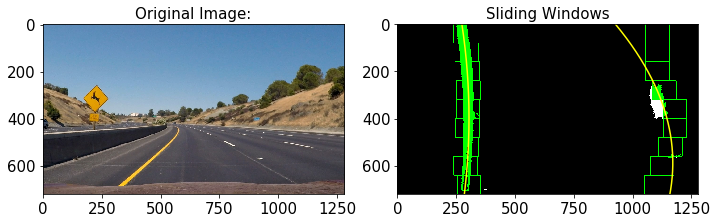

In [21]:
LEFT = Line()
RIGHT = Line()
AVG = Line()
def sliding_windows(binary_warped):    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 50
    minpix = 1
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
    
    #For Video:
    LEFT.recent_xfits = [(left_fitx)]
    LEFT.best_xfit = np.mean(LEFT.recent_xfits)
    RIGHT.recent_xfits = [(right_fitx)]
    RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
        
    LEFT.current_fit_coeffs = [(left_fit)]
    LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
    RIGHT.current_fit_coeffs = [(right_fit)]
    RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
    
    LEFT.line_base_position = leftx_current
    RIGHT.line_base_position = rightx_current
    
    LEFT.allx = leftx
    LEFT.ally = lefty
    RIGHT.allx = rightx
    RIGHT.ally = righty
    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base


pipeline(op='Sliding Windows')

### Fitting Shaded Lines

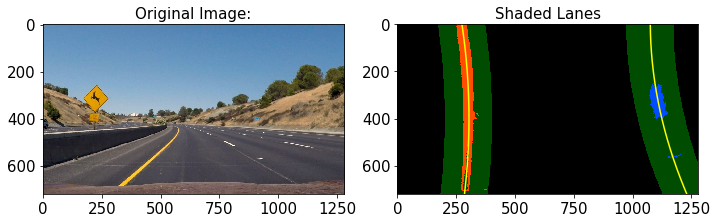

In [22]:
def shaded_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    if left_fitx.all() != 0:
        LEFT.detected == True
    else:
        LEFT.detected == False
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    if right_fitx.all() != 0:
        RIGHT.detected == True
    else:
        RIGHT.detected == False
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit

pipeline(op='Shaded Lanes')

## 6. Determine the curvature of the lane and vehicle position with respect to center.

### Determine the curvature of the lane

In [23]:
def roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad
        
pipeline(op='Radius of Curvature in Pixels')

Left Radius of Curvature: 2677.683023 pixels
Right Radius of Curvature: 2857.903513 pixels



### Conversions in x and y from pixels space to meters

In [24]:
def roc_in_meters(ploty, left_fit, right_fit, leftx, lefty,rightx,righty):

   
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)


    xm_per_pix = 3.7/700 # meteres/pixel in x dimension
    ym_per_pix = 30.0/720 # meters/pixel in y dimension
    
    y_eval = np.max(ploty)
   
    #left_fit_cr = np.polyfit(leftx*ym_per_pix, leftx*xm_per_pix, 2)   wrongly implemented
    #right_fit_cr = np.polyfit(rightx*ym_per_pix, rightx*xm_per_pix, 2) wrongly implemented
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
#   left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#   right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                             /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])

    avg_curverad =  (left_curverad + right_curverad)/2
    #For Video:
    
    LEFT.radius_of_curvature = left_curverad
    RIGHT.radius_of_curvature = right_curverad
    AVG.radius_of_curvature = avg_curverad
    return left_curverad, right_curverad, avg_curverad
        
pipeline(op='Radius of Curvature in Meters')

Left Radius of Curvature: 1810.511962 pixels
Right Radius of Curvature: 1721.750935 pixels
Radius of Curvature: 1766.131449 



### Determining Vehicle Position with respect to Center

In [25]:
def offset(img_center, leftx_base, rightx_base):
    poly_center = (leftx_base + rightx_base) / 2
    diff_pix = img_center - poly_center
    xm_per_pix = 3.5/1000
    offset = diff_pix * xm_per_pix
    return offset
pipeline(op='Camera Offset')

Offset from Lane Center: -0.224000 meters



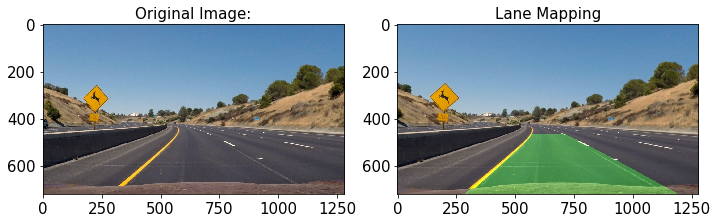

In [26]:
def lane_mapping(img_shape, warped, Minv, ploty, left_fitx, right_fitx, undistorted):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0)) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[1], img_shape[0])) 
    out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return out_img

pipeline(op='Lane Mapping')

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [27]:
best_fit_test_images = glob.glob('output_images/test*_top_view.jpg')
n_frames = 0

def video_pipeline(img):
    global n_frames
    if n_frames == 0:
        undistorted = undistort(img)
        binary_thresholded = combined_thresholds(undistorted)
        warped, M, Minv = transform_perspective(binary_thresholded)
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(warped)   
        left_curverad, right_curverad,avg_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, lefty,rightx,righty)
        camera = offset(img.shape[1]/2, leftx_base, rightx_base)
        out_img = lane_mapping(img.shape[:2], warped, Minv, ploty, left_fitx, right_fitx, undistorted)
        annotate(out_img, left_curverad, right_curverad, camera)
    else:
        undistorted = undistort(img)
        binary_thresholded = combined_thresholds(undistorted)
        region = region_of_interest(binary_thresholded)
        warped, M, Minv = transform_perspective(region)
        binary_warped = warped
        
        if LEFT.detected == True:
            left_fit = LEFT.current_fit_coeffs
        else:
            left_fit = LEFT.best_fit_coeffs
        
        if RIGHT.detected == True:
            right_fit = RIGHT.current_fit_coeffs
        else:
            right_fit = RIGHT.best_fit_coeffs
        
        windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty, rightx,righty, leftx_base, rightx_base = sliding_windows(warped)   

        if LEFT.detected == True:
            LEFT.recent_xfits.append((left_fitx))
            LEFT.best_xfit = np.mean(LEFT.recent_xfits)
            LEFT.current_fit_coeffs.append((left_fit))
            LEFT.best_fit_coeffs = np.mean(LEFT.current_fit_coeffs)
            LEFT.line_base_position = leftx_current
            LEFT.allx = leftx
            LEFT.ally = lefty
        else:
            left_fitx = LEFT.best_xfit
            left_fit = LEFT.best_fit_coeffs
            leftx_current = LEFT.line_base_position
            leftx = LEFT.allx
            lefty = LEFT.ally   
        if RIGHT.detected == True:
            RIGHT.recent_xfits.append((right_fitx))
            RIGHT.best_xfit = np.mean(RIGHT.recent_xfits)
            RIGHT.current_fit_coeffs.append((right_fit))
            RIGHT.best_fit_coeffs = np.mean(RIGHT.current_fit_coeffs)
            RIGHT.line_base_position = rightx_current
            RIGHT.allx = rightx
            RIGHT.ally = righty   
        else:
            right_fitx = RIGHT.best_xfit
            right_fit = RIGHT.best_fit_coeffs
            rightx_current = RIGHT.line_base_position
            rightx = RIGHT.allx
            righty = RIGHT.ally
            
        is_lane_width_correct = verify_lane_width(LEFT.line_base_position, RIGHT.line_base_position)
        if is_lane_width_correct == True:
            LEFT.detected = True
            RIGHT.detected = True
        else:
            LEFT.detected = False
            RIGHT.detected = False
                
        left_curverad, right_curverad,avg_curverad =  roc_in_meters(ploty, left_fit, right_fit, leftx, lefty,rightx,righty)
        LEFT.radius_of_curvature = left_curverad
        RIGHT.radius_of_curvature = right_curverad
        AVG.radius_of_curvature = avg_curverad
        leftx_base = leftx_current
        rightx_base = rightx_current
        camera = offset(img.shape[1]/2, leftx_base, rightx_base, n_frames)
        
        out_img = lane_mapping(img.shape[:2], warped, Minv, ploty, left_fitx, right_fitx, undistorted)
        annotate(out_img, left_curverad, right_curverad, camera)    
    return out_img

In [28]:
from moviepy.editor import VideoFileClip

video_output = 'P4_video_final.mp4'
clip = VideoFileClip('project_video.mp4')

output_clip = clip.fl_image(video_pipeline)
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video P4_video_final.mp4
[MoviePy] Writing video P4_video_final.mp4


100%|█████████▉| 1260/1261 [08:13<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_video_final.mp4 

CPU times: user 5min 2s, sys: 1min 2s, total: 6min 4s
Wall time: 8min 16s


In [29]:
from IPython.display import HTML
output1 = 'P4_video_final.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

In [ ]:
from moviepy.editor import VideoFileClip

video_output = 'challenge_video_output.mp4'
clip = VideoFileClip('challenge_video.mp4')

output_clip2 = clip.fl_image(video_pipeline)
%time output_clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


 13%|█▎        | 64/485 [00:23<02:53,  2.42it/s]

In [ ]:
from IPython.display import HTML
output2 = 'challenge_video_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))